In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import seaborn as sns

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources

In [3]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_EGS/data/holes_EGS_irac_i1_O16_20190201_WARNING-MADE-WITH-Lockman-SWIRE-PARAMS.fits')
#EGS_MOC=pymoc.MOC()
#EGS_MOC.read('../../dmu17/dmu17_HELP_Legacy_maps/EGS/data/')
Final=Sel_func

In [4]:
Final.write('./data/testMoc.fits', overwrite=True)

## Read in XID+MIPS catalogue

In [5]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_EGS/data/dmu26_XID+MIPS_EGS_Legacy_cat_20190504.fits')

In [6]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J141442.003+515539.339,213.67501162574598,51.9275942135701,25.766361,38.14536,14.193435,0.006743462,4.698811e-06,1.0017574,2000.0,0.886,True
HELP_J141433.793+515648.049,213.640805625746,51.946680213570104,33.748978,46.78966,22.085533,0.0054108673,6.5491963e-06,0.9989234,2000.0,0.96,True
HELP_J141434.323+515636.892,213.643012625746,51.9435812135701,8.178729,17.812885,2.0967233,0.0054108673,6.5491963e-06,0.9989096,2000.0,0.0,False
HELP_J141433.496+515638.383,213.639566625746,51.9439952135701,13.585008,24.973873,4.664922,0.0054108673,6.5491963e-06,1.00019,2000.0,0.0,False
HELP_J141435.953+515625.999,213.649803625746,51.9405552135701,4.820643,12.095559,1.2133089,0.0054108673,6.5491963e-06,1.0012287,2000.0,0.0,True
HELP_J141430.989+515703.982,213.629120625746,51.9511062135701,1.9176259,4.8693743,0.43551552,0.0054108673,6.5491963e-06,0.99868613,2000.0,0.111,True
HELP_J141435.396+515629.142,213.647481625746,51.9414282135701,1.0996143,2.829807,0.27576494,0.0054108673,6.5491963e-06,1.0008005,2000.0,0.025,True
HELP_J141431.870+515653.960,213.632791625746,51.9483222135701,70.69443,82.93328,58.79714,0.0054108673,6.5491963e-06,0.99847925,2000.0,0.0,False


4.9990883
10041


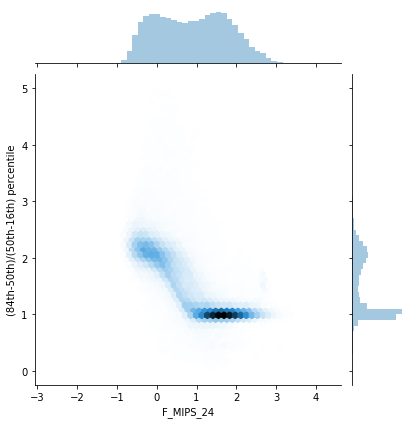

In [7]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))


The uncertianties become Gaussian by $\sim 5 \mathrm{\mu Jy}$

In [8]:
good=XID_MIPS['F_MIPS_24']>5
print(len(good))

126287


In [9]:
good.sum()

68381

## Read in Maps

In [10]:
pswfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/EGS_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/EGS_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/EGS_SPIRE500_v1.0.fits'#SPIRE 500 map

#output folder
output_folder='./data/'

In [11]:

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['IMAGE'].header

im250=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim250=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['IMAGE'].header)
pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['IMAGE'].header

im350=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim350=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['IMAGE'].header)
pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['IMAGE'].header

im500=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim500=hdulist['ERROR'].data*1.0E3 #convert to mJy
w_500 = wcs.WCS(hdulist['IMAGE'].header)
pixsize500=3600.0*w_500.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

In [13]:
## Set XID+ prior class

In [12]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_EGS_cat_20190504.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Final)
prior350.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_EGS_cat_20190504.fits',ID=XID_MIPS['help_id'][good])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Final)
prior500.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_EGS_cat_20190504.fits',ID=XID_MIPS['help_id'][good])
prior500.prior_bkg(-5.0,5)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [13]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [14]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 64 tiles required for input catalogue and 4 large tiles


SystemExit: 